In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance, DMatrix
import seaborn as sns
from matplotlib import pyplot

In [2]:
df = pd.read_csv("covid-selected-data.csv")

In [3]:
df

,Unnamed: 0,SLPI,SCGB1A1,SCGB3A1,IGLV3-19,IGHV4-34,WFDC2,BPIFB1,IGHG1,GNLY,...,AL121748.1,AC091271.1,TMPRSS11A,GPR42,MAATS1,RNASE6,CLLU1OS,AL138781.1,KIR3DX1,BX284668.6
0,AAACCTGAGACACTAA_1-0,-0.299600,-0.209672,-0.303414,-0.124916,-0.029675,-0.173679,-0.245457,-0.045119,-0.232438,...,-0.002161,-0.278853,-0.049338,-0.067806,0.014586,3.340670,0.013455,-0.063450,-0.044314,0.356231
1,AAACCTGAGGATATAC_1-0,-0.174449,-0.188095,-0.307278,-0.030387,0.127351,-0.167250,-0.202737,-0.146072,-0.312133,...,-0.023173,-0.134107,-0.049219,-0.005433,-0.122310,-0.561601,-4.031731,-0.152772,-0.077827,-0.037313
2,AAACCTGAGGTCATCT_1-0,-0.250839,0.001586,-0.158335,-0.127563,-0.286497,-0.231720,-0.295893,-0.014139,-0.198845,...,-0.049942,0.061155,-0.049338,-0.032648,-0.053740,-0.001551,0.046797,-0.031315,-0.116844,0.011145
3,AAACGGGAGCTACCTA_1-0,-0.185059,-0.212178,-0.297900,0.145107,0.185361,-0.150315,-0.121878,-0.004044,-0.301263,...,-0.021301,-0.128485,-0.049338,-0.045541,-0.105046,-0.603013,-0.060725,-0.093516,0.448147,-0.053735
4,AAACGGGAGGAATTAC_1-0,-0.225948,-0.124393,-0.150766,-0.106845,0.062172,-0.144326,-0.135881,-0.112006,-0.284480,...,-0.034778,-0.134924,-0.061330,0.373200,-0.112133,-0.678061,0.027075,-0.127998,-0.095437,-0.039752
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23184,TACCTATAGATAGGAG_12-8,-0.318609,-0.147689,-0.014733,-0.066722,-0.022243,-0.265810,-0.429172,0.116468,-0.318654,...,-0.014737,-0.167184,-0.049338,-0.084465,-0.081504,-0.393784,-4.903649,-0.053283,-0.078166,-0.065026
23185,TGCACCTGTGTTGAGG_12-8,-0.497504,-0.145024,-0.076858,-0.062486,-0.022538,-0.300655,-0.466926,0.260027,0.044564,...,-0.319704,-0.140568,-0.049338,-0.076532,-0.051753,0.025898,-0.078744,-0.113807,-0.083385,0.520675
23186,TGGTTCCGTTGGGACA_12-8,-0.183404,-0.161766,-0.050538,-0.263814,-0.133959,-0.246133,-0.246135,-0.242795,-0.392169,...,-0.015287,-0.411534,-0.049338,-0.074751,-0.072872,-0.493291,-0.175105,-0.045720,-0.110362,0.635520
23187,TTCTACATCCGCAGTG_12-8,-0.343561,-0.177203,-0.047329,-0.751049,-0.022538,-0.266771,-0.301871,-0.514029,-0.308518,...,-1.964515,-0.043751,-0.049338,-0.109876,-0.118249,-0.276349,-0.088472,-0.156365,-0.114206,-2.235231


In [4]:
def get_dataset(return_X=True):
    classes = ['Normal', 'Mild', 'Severe']
    y = []
    labels = pd.read_csv("covid-selected-data-labels.csv").set_index('Unnamed: 0').to_numpy()[:,0]
    for label in labels:
        y.append(classes.index(label))
        
    if not return_X:
        return np.array(y, dtype=int)
    
    X = pd.read_csv("covid-selected-data.csv").set_index('Unnamed: 0').to_numpy()
    
    return X, np.array(y, dtype=int)

In [5]:
def data_split():
    y = get_dataset(return_X=False)
    X = np.zeros(len(y))
    split_indices = []
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in skf.split(X, y):
        split_indices.append((train_index, test_index))

    return split_indices

In [6]:
split_indices = data_split()
np.save('idx_split.npy', split_indices)

C:\Users\CHI-visitor1\anaconda3\lib\site-packages\numpy\core\_asarray.py:171: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order, subok=True)


In [7]:
def train_and_test(model_name, svm_kernel='rbf'):
    X, y = get_dataset()
    split_indices = np.load('idx_split.npy', allow_pickle=True).tolist()
    y_pre, y_pre_proba, y_tru = np.array([]), [], np.array([])

    for train_indices, test_indices in split_indices:
        X_train, X_test = X[train_indices], X[test_indices]
        y_train, y_test = y[train_indices], y[test_indices]

        if model_name=='LR':
            model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10000)
        elif model_name=='KNN':
            model = KNeighborsClassifier()
        elif model_name=='SVM':
            model = SVC(kernel=svm_kernel)
        elif model_name=='XGBoost':
            model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
        elif model_name=='RF':
            model = RandomForestClassifier()
        else:
            print('No matched classifiers')
            return
        
        model.fit(X_train, y_train)
        y_test_pre = model.predict(X_test)
        y_test_pre_proba = model.predict_proba(X_test)
        y_pre = np.concatenate((y_pre, y_test_pre))
        y_pre_proba.append(y_test_pre_proba)
        y_tru = np.concatenate((y_tru, y_test))

    return {'pre': y_pre, 'pre_proba':np.vstack(y_pre_proba), 'tru': y_tru}

In [8]:
def plot_heatmap(res, model_name):
    print('Model:', model_name)
    classes = ['Normal', 'Mild', 'Severe']
    y_pred, y_pred_proba, y_test = res['pre'].astype(int), res['pre_proba'], res['tru'].astype(int)
    
    auroc_ovr_macro = roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovr')
    auroc_ovr_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')
    auroc_ovo_macro = roc_auc_score(y_test, y_pred_proba, average='macro', multi_class='ovo')
    auroc_ovo_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovo')
    print('AUROC OVR Macro: %.2f%%' % (auroc_ovr_macro*100))
    print('AUROC OVR Weighted: %.2f%%' % (auroc_ovr_weighted*100))
    print('AUROC OVO Macro: %.2f%%' % (auroc_ovo_macro*100))
    print('AUROC OVO Macro: %.2f%%' % (auroc_ovo_weighted*100))
    
    vis = confusion_matrix(y_test, y_pred)
    accu = accuracy_score(y_test, y_pred)
    
    #print(classification_report(y_test, y_pred))
    print('Accuracy: %.2f%%' % (accu*100))
    
    pd_vis = pd.DataFrame(vis, columns=classes, index=classes)
    ax = sns.heatmap(pd_vis, cmap="Blues", annot=True, fmt='d')

In [ ]:
res_xgboost, xgb = train_and_test('XGBoost')

Model: XGBoost
AUROC OVR Macro: 100.00%
AUROC OVR Weighted: 100.00%
AUROC OVO Macro: 100.00%
AUROC OVO Macro: 100.00%
Accuracy: 99.83%


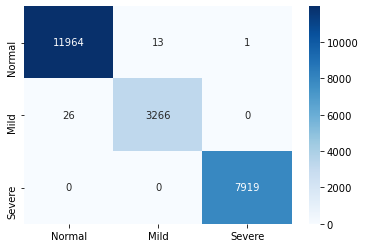

In [12]:
plot_heatmap(res_xgboost, 'XGBoost')

In [13]:
res_rf = train_and_test('RF')

Model: Random Forest
AUROC OVR Macro: 99.99%
AUROC OVR Weighted: 99.99%
AUROC OVO Macro: 99.98%
AUROC OVO Macro: 99.98%
Accuracy: 99.25%


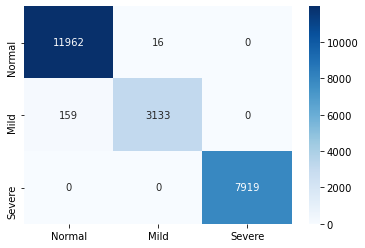

In [15]:
plot_heatmap(res_rf, 'Random Forest')

In [5]:
X, y = get_dataset()
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='mlogloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [47]:
xgb.importance_type

'gain'

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

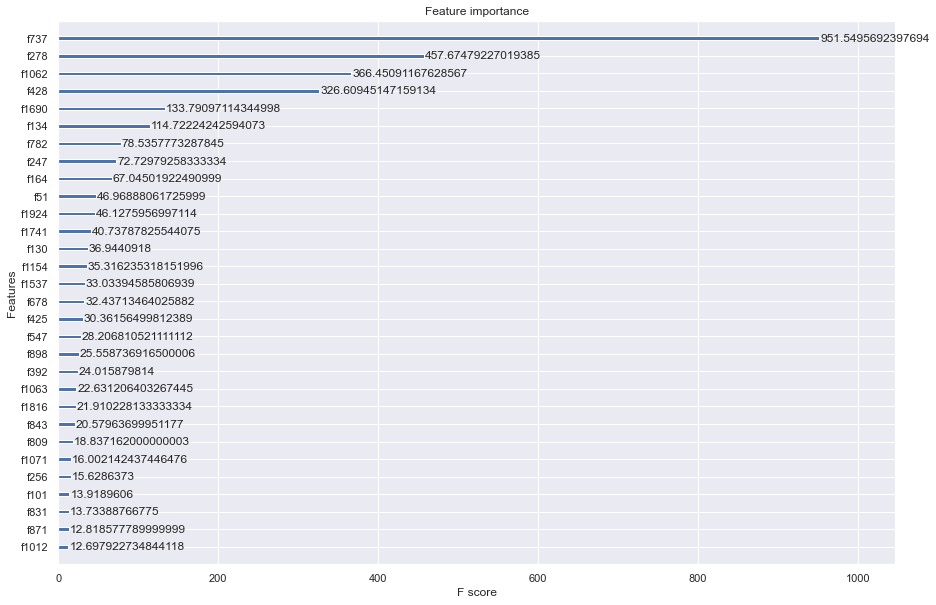

In [71]:
fig,ax = pyplot.subplots(figsize=(15,10))
plot_importance(xgb, ax = ax, importance_type = "gain", max_num_features = 30)

In [62]:
feat_imp = pd.DataFrame()
feat_imp["feat_name"] = df.columns.to_numpy()[1:]
feat_imp["gain_importance"] = xgb.feature_importances_
feat_imp.sort_values(by = ['gain_importance'],ascending = False, inplace = True)
feat_imp

,feat_name,gain_importance
737,IGKV2D-30,0.233296
278,TRAV38-1,0.112210
1062,F13A1,0.089844
428,CD207,0.080076
1690,PTGER2,0.032802
...,...,...
885,ARMC3,0.000000
884,RDH10,0.000000
883,SPINK2,0.000000
880,GALNT5,0.000000


In [63]:
feat_imp.to_csv("feature_importance.csv",index_label = "feat_idx")